# Homework 04:  Null Values, Categorical Features, and Cross Validation

In this homework, we are going to add three **tools to your toolbox** which will be essential when you work with real datasets:
1. What do we do with null-values?
2. How do we deal with non-numeric features?
3. What validation strategy provides the best estimate of the final testing score?

For (1), we'll explore several ways of dealing with null values:
- Removing columns with too many null values,
- Imputing values for missing categorical labels using the "most frequent" category strategy, and
- Imputing values for missing numeric values using the median. 


For (2), we'll use ordinal encoding to replace categorical labels with floats.

For (3), we'll try three different cross-validation strategies:

- 5-Fold CV,
- Repeated 5-Fold CV, and
- Leave one out CV, 

and see which comes closest to estimating the final testing MSE. 


#### Grading: There are eight (8) answers to provide, each worth 6 points.  (You get 2 points for free.)
 

In [153]:
# Useful imports

import os
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, LeaveOneOut
from sklearn.linear_model    import LinearRegression
from sklearn.preprocessing   import OrdinalEncoder, OneHotEncoder  
from sklearn.impute          import SimpleImputer
from sklearn.metrics         import mean_squared_error, r2_score
from tqdm                    import tqdm



### Load the Ames Housing Dataset

For a description of the features of this dataset, see the **Appendix**. 

In [154]:
# Download the latest version of the dataset
path = kagglehub.dataset_download("shashanknecrothapa/ames-housing-dataset")

# print("Path to dataset files:", path)

# Construct the full path to the CSV file (update the file name if necessary)
csv_file = os.path.join(path, "AmesHousing.csv")

# Read the dataset into a DataFrame
df = pd.read_csv(csv_file)

In [155]:
# Print the first few rows of the DataFrame
df.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [156]:
# Uncomment this to see the listing of features

# df.info()

In [157]:
# Uncomment this to see the feature histograms

# print("Feature Histograms")
# df.hist(figsize=(15, 13), bins=30)  # Adjust figure size and number of bins
# plt.tight_layout()  # Adjust spacing to prevent overlap
# plt.show()

### Data Preprocessing

First, let's remove the features that are clearly not useful for regression.

In [158]:
df_clean = df.drop(columns=['Order','PID'])
df_clean.head()

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


### Problem One: Dealing with Null Values

There are basically two strategies for dealing with missing (null or `NaN`) values:
- Get them out of your dataset by **removing** features and/or samples containing too many nulls.
- **Impute** values by replacing nulls with the mean, median, or other "neutral" value computed from the feature.

**Note:** It is also possible to impute values using more advanced techniques such as mode imputation, forward/backward fill, or predictive modeling (e.g., KNN or regression-based imputation). These techniques might be useful when you start to work on your projecct. 

**First we will explore how many null values occur in each feature.**

In [159]:
# This function will list how many nulls occur in which features

def show_null_counts_features(df):
    # Count the nulls and calculate the %
    count_nulls = df.isnull().sum()
    df_nulls = (df.isnull().mean() * 100).round(2)
    
    # Determine if the column is numeric or non-numeric
    feature_types = df.dtypes.apply(lambda x: 'Numeric' if np.issubdtype(x, np.number) else 'Categorical')
    
    # Filter out the columns with missing values and sort them in descending order
    missing_data = pd.DataFrame({
        'Feature': count_nulls[count_nulls > 0].index,
        '# Null Values': count_nulls[count_nulls > 0].values, 
        'Null %': df_nulls[df_nulls > 0].values,
        'Type': feature_types[count_nulls > 0].values
    }).sort_values(by='Null %', ascending=False)
    
    print(f'The dataset contains {len(df)} samples.\n')

    if (len(missing_data) == 0):
        print("There are no null values in the dataset!")
    else:
        # Print null value stats
        print('Feature Name    # Nulls      Null %    Type')
        print('------------    -------      ------    ----')
        for index, row in missing_data.iterrows():
            print(f"{row['Feature']:<15} {row['# Null Values']:<12} {row['Null %']:.2f}%   {row['Type']}")

show_null_counts_features(df_clean)

The dataset contains 2930 samples.

Feature Name    # Nulls      Null %    Type
------------    -------      ------    ----
Pool QC         2917         99.56%   Categorical
Misc Feature    2824         96.38%   Categorical
Alley           2732         93.24%   Categorical
Fence           2358         80.48%   Categorical
Mas Vnr Type    1775         60.58%   Categorical
Fireplace Qu    1422         48.53%   Categorical
Lot Frontage    490          16.72%   Numeric
Garage Qual     159          5.43%   Categorical
Garage Cond     159          5.43%   Categorical
Garage Yr Blt   159          5.43%   Numeric
Garage Finish   159          5.43%   Categorical
Garage Type     157          5.36%   Categorical
Bsmt Exposure   83           2.83%   Categorical
BsmtFin Type 2  81           2.76%   Categorical
Bsmt Cond       80           2.73%   Categorical
Bsmt Qual       80           2.73%   Categorical
BsmtFin Type 1  80           2.73%   Categorical
Mas Vnr Area    23           0.78%   Numeric

### Part A

Clearly, some of these features are not very informative! Let's drop the worst offenders!

**Fill in your code after the comments below to drop any features with more than `max_nulls` null values.**


In [160]:
max_nulls = 500      # We will drop any features with more than max_nulls missing values

# Count null values per column
null_counts = df_clean.isnull().sum()
#print(f"null_counts: \n{null_counts.head()}")
#print(f"\n")

# Filter out columns where null count exceeds max_nulls
columns_to_drop = null_counts[null_counts > max_nulls].index
#print(f"columns_to_drop: \n{columns_to_drop}")
#print(f"\n")

number_of_columns_to_drop = len(columns_to_drop)
print(f"number of columns_to_drop: {number_of_columns_to_drop}")

#print(f"\n")

# Drop the columns
df_clean = df_clean.drop(columns=columns_to_drop)
#print(f"df_clean: \n{df_clean.head()}")
#print(f"\n")

# Uncomment to verify they were removed

show_null_counts_features(df_clean)

number of columns_to_drop: 6
The dataset contains 2930 samples.

Feature Name    # Nulls      Null %    Type
------------    -------      ------    ----
Lot Frontage    490          16.72%   Numeric
Garage Finish   159          5.43%   Categorical
Garage Yr Blt   159          5.43%   Numeric
Garage Qual     159          5.43%   Categorical
Garage Cond     159          5.43%   Categorical
Garage Type     157          5.36%   Categorical
Bsmt Exposure   83           2.83%   Categorical
BsmtFin Type 2  81           2.76%   Categorical
Bsmt Qual       80           2.73%   Categorical
BsmtFin Type 1  80           2.73%   Categorical
Bsmt Cond       80           2.73%   Categorical
Mas Vnr Area    23           0.78%   Numeric
Bsmt Full Bath  2            0.07%   Numeric
Bsmt Half Bath  2            0.07%   Numeric
Electrical      1            0.03%   Categorical
Bsmt Unf SF     1            0.03%   Numeric
BsmtFin SF 2    1            0.03%   Numeric
BsmtFin SF 1    1            0.03%   Nume

In [161]:
# Set this variable to the number of cells that were dropped

a1a = 6

print(f"a1a = {a1a}")                                   # Don't delete or change this line, it is needed by the auto-grader

a1a = 6


### Part B:  Feature Transformations for Imputing Null Values

Now let's perform the following feature transformations:

- For categorical features, we'll replace null values with the most frequent category in that column
- For numeric features, we'll replace nulls with the median for that column


This is very simple to do with a couple of lines of Python, but naturally we want to use `sklearn` functions whenever we can, so we'll use ` SimpleImputer`.

**Go read the doc page for `SimpleImputer` before proceeding.**

### Imputing Categorical Features using the Most Frequent Strategy

In the next cell you see how easy it is to examine the categories. **Take a moment and explore several of the categorical features.**  In this dataset, most of them are skewed, with a clear "most favorite" category. 
(If the feature values are not skewed, then you could change these to a new category "Unknown".)

In [162]:
df_clean['Garage Qual'].value_counts(dropna=False)

Garage Qual
TA     2615
NaN     159
Fa      124
Gd       24
Po        5
Ex        3
Name: count, dtype: int64

Before proceeding, let's get lists of the two types of features.

In [163]:
# Identify categorical and numeric features

categorical_features = df_clean.select_dtypes(exclude=['number']).columns.tolist()
numeric_features     = df_clean.select_dtypes(include=['number']).columns.tolist()

# Print results if you want
print("Categorical Features:", categorical_features)
print(f"\n")
print("Numeric Features:", numeric_features)

Categorical Features: ['MS Zoning', 'Street', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating', 'Heating QC', 'Central Air', 'Electrical', 'Kitchen Qual', 'Functional', 'Garage Type', 'Garage Finish', 'Garage Qual', 'Garage Cond', 'Paved Drive', 'Sale Type', 'Sale Condition']


Numeric Features: ['MS SubClass', 'Lot Frontage', 'Lot Area', 'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces', 'Garage Yr Blt', 'Garage Cars', 'Garage A

**Now you must impute all the categorical features using `SimpleImputer` with the `most_frequent` strategy.**

In [164]:
# First make a copy of the cleaned dataset, call it df_imputed
df_imputed = df_clean.copy()

# Impute categorical columns (using most frequent category)
categorical_features = df_imputed.select_dtypes(exclude=['number']).columns
categorical_features
df_imputed[categorical_features] = SimpleImputer(strategy='most_frequent').fit_transform(df_imputed[categorical_features])
df_imputed

# Verify: only numeric features should appear

show_null_counts_features(df_imputed)



The dataset contains 2930 samples.

Feature Name    # Nulls      Null %    Type
------------    -------      ------    ----
Lot Frontage    490          16.72%   Numeric
Garage Yr Blt   159          5.43%   Numeric
Mas Vnr Area    23           0.78%   Numeric
Bsmt Half Bath  2            0.07%   Numeric
Bsmt Full Bath  2            0.07%   Numeric
BsmtFin SF 1    1            0.03%   Numeric
BsmtFin SF 2    1            0.03%   Numeric
Total Bsmt SF   1            0.03%   Numeric
Bsmt Unf SF     1            0.03%   Numeric
Garage Cars     1            0.03%   Numeric
Garage Area     1            0.03%   Numeric


In [165]:
df_imputed['Garage Qual'].value_counts(dropna=False)
(df_imputed['Garage Qual'] == 'TA').sum()

np.int64(2774)

In [166]:
# Set this variable to the number of occurrences of the category 'TA' in the feature 'Garage Qual'
# It should have increased from before the imputation, because Nan values were changed to 'TA'

a1b = 2774     

print(f"a1b = {a1b}")                                   # Don't delete or change this line, it is needed by the auto-grader

a1b = 2774


### Part C:  Imputing Numeric Features using the Median

Now you must "simply impute" values for the numeric features using the `median` strategy. 

In [167]:
# Impute numeric columns (using the median)
df_imputed[numeric_features] = SimpleImputer(strategy='median').fit_transform(df_imputed[numeric_features])
#df_imputed
# Verify: There should be no null values

show_null_counts_features(df_imputed)

The dataset contains 2930 samples.

There are no null values in the dataset!


In [168]:
# Nothing to do here:   Answer should be 0 

a1c = df_imputed.isnull().any(axis=1).sum()      # count number of rows with any missing values

print(f"a1c = {a1c}")                            # Don't delete or change this line, it is needed by the auto-grader

a1c = 0


### Part D:   Ordinal encoding the categorical features with OrdinalEncoder

The simplest option in dealing with categorical values is to represent them by integers 0, 1, 2, etc.

**Before proceeding, read the doc page on `sklearn`'s `OrdinalEncoder`.**

Follow the comments to perform this feature transformation

In [169]:
# Put df_imputed in the form X, y
X = df_imputed.drop(columns=['SalePrice'])
y = df_imputed['SalePrice']

# Initialize OrdinalEncoder
ordinal_encoder = OrdinalEncoder()


# Fit and transform categorical columns
X[categorical_features] = ordinal_encoder.fit_transform(X[categorical_features])

# Convert back to DataFrame to retain column names 
X = pd.DataFrame(X, columns=df_imputed.drop(columns=['SalePrice']).columns)

# Verify

X.head()

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,...,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition
0,20.0,5.0,141.0,31770.0,1.0,0.0,3.0,0.0,0.0,0.0,...,62.0,0.0,0.0,0.0,0.0,0.0,5.0,2010.0,9.0,4.0
1,20.0,4.0,80.0,11622.0,1.0,3.0,3.0,0.0,4.0,0.0,...,0.0,0.0,0.0,120.0,0.0,0.0,6.0,2010.0,9.0,4.0
2,20.0,5.0,81.0,14267.0,1.0,0.0,3.0,0.0,0.0,0.0,...,36.0,0.0,0.0,0.0,0.0,12500.0,6.0,2010.0,9.0,4.0
3,20.0,5.0,93.0,11160.0,1.0,3.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2010.0,9.0,4.0
4,60.0,5.0,74.0,13830.0,1.0,0.0,3.0,0.0,4.0,0.0,...,34.0,0.0,0.0,0.0,0.0,0.0,3.0,2010.0,9.0,4.0


In [170]:
# Nothing to do here:   Answer should show categories encoded as floats for 'Lot Shape'

a1d = X['Lot Shape'].unique()                      

print(f"a1d = {a1d}")                            # Don't delete or change this line, it is needed by the auto-grader

a1d = [0. 3. 1. 2.]


## Problem Two:  Train and Test a Regression Model with Cross-Validation

In this problem, we will perform a regression on the Ames Housing Dataset using several different cross-validation
strategies, comparing the cross-validation score for each with the final testing MSE, to see which provides the best
estimate of the final test score, and hence of the model's ability to generalize. 


We shall compare each of the following cross-validation MSEs with the final test MSE score:

- 5-Fold Cross-Validation (default)
- Repeated 5-Fold Cross-Validation (repeated 100 times)
- Leave-One-Out Cross Validation

**Note:  Set `n_jobs = -1` when doing cross validation to take advantage of parallelism in your environment.** 

### Part A: 5-Fold Cross-Validation

For this part
- Create a train-test split with `test_size=0.2` 
- Create a linear model and perform K-fold cross-validation with K = 5 and using `cross_val_score` with `scoring='neg_mean_squared_error'` (remember to take the mean of the CV scores and negate the result, since scoring uses a negative MSE). 
- Report (print out) the
    - CV score (negated mean of MSE measurements over all K folds)
    - Test MSE


Use `random_state = 42` for all experiments. 

In [171]:
# Your code here

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# linear Regression with 5-Fold CV
model = LinearRegression()
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
cv_mean_score = -np.mean(cv_scores)

# train model
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
# calculate test MSE
test_mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: ${test_mse:,.2f}")

rmse_test = np.sqrt(test_mse)
print(f"Test RMSE: ${rmse_test:,.2f}")


Test MSE: $1,118,604,729.66
Test RMSE: $33,445.55


In [172]:
# Assign to this variable the Test MSE 

a2a = test_mse              

print(f"a2a = {a2a:.4f}")                            # Don't delete or change this line, it is needed by the auto-grader

a2a = 1118604729.6597


## Part B: Perform Repeated 5-Fold Cross Validation

Read the doc page on `sklearn`'s `RepeatedKFold` for cross validation; repeat the CV calculation with K = 5 and `n_repeats=100`
and report the CV score (negated mean of MSE measurements over all 100*K folds)

In [173]:
# Your code here
# repeated 5-Fold CV
repeated_kfold = RepeatedKFold(n_splits=5, n_repeats=100, random_state=42)
cv_repeated_scores = cross_val_score(model, X_train, y_train, cv=repeated_kfold, scoring='neg_mean_squared_error', n_jobs=-1)

cv_repeated_mean_score = -np.mean(cv_repeated_scores)
print(f"cv_repeated_mean_score: ${cv_repeated_mean_score:,.2f}")



cv_repeated_mean_score: $1,077,441,553.37


In [174]:
# Assign to this variable the mean CV score for the repeated K-fold experiment 
# Note: if your CV score is negative, go back and read the instructions for Part A again!

a2b = cv_repeated_mean_score             

print(f"a2b = {a2b:.4f}")                            # Don't delete or change this line, it is needed by the auto-grader

a2b = 1077441553.3662


## Part C: Perform Leave One Out Cross Validation

This is simply a matter of setting `cv=LeaveOneOut()`. Run the same experiment and report the CV score. 

In [175]:
# Your code here

loo = LeaveOneOut()
cv_loo_scores = cross_val_score(model, X_train, y_train, cv=loo, scoring='neg_mean_squared_error', n_jobs=-1)
cv_loo_mean_score = -np.mean(cv_loo_scores)

print(f"cv_loo_mean_score: ${cv_loo_mean_score:c.2f}")



ValueError: Invalid format specifier 'c.2f' for object of type 'float'

In [ ]:
# Assign to this variable the mean CV score for the leave-one-out experiment 

a2c = cv_loo_mean_score               

print(f"a2c = {a2c:.4f}")                            # Don't delete or change this line, it is needed by the auto-grader

a2c = 1053535727.6073


### Part D

Now, in order to help interpret the results, print out a table of the **square roots** of each of the CV scores and the final test score; we can then see the result in the same units (dollars) as the target, instead of the units of the MSE (dollars squared). 

Hint: Here is an example of how to print out values as currency:

    cost = 23512.23
    print(f"cost: ${cost:,.2f}")

In [ ]:
# Your code here 

rmse_test = np.sqrt(test_mse)
rmse_cv_5fold = np.sqrt(cv_mean_score)
rmse_cv_repeated = np.sqrt(cv_repeated_mean_score)
rmse_cv_loo = np.sqrt(cv_loo_mean_score)
rmse_diffs = {'A': abs(rmse_cv_5fold - rmse_test), 'B': abs(rmse_cv_repeated - rmse_test), 'C': abs(rmse_cv_loo - rmse_test)}
closest_cv = min(rmse_diffs, key=rmse_diffs.get)
closest_cv

'B'

In [ ]:
print(f"rmse_test: ${rmse_test:,.2f}")
print(f"rmse_cv_5fold: ${rmse_cv_5fold:,.2f}")
print(f"rmse_cv_repeated: ${rmse_cv_repeated:,.2f}")
print(f"rmse_cv_loo: ${rmse_cv_loo:,.2f}")
print(f"rmse_diffs: {rmse_diffs}")
print(f"closest_cv: {closest_cv}")

rmse_test: $33,445.55
rmse_cv_5fold: $31,485.41
rmse_cv_repeated: $32,824.40
rmse_cv_loo: $32,458.22
rmse_diffs: {'A': np.float64(1960.136066376057), 'B': np.float64(621.1438830910192), 'C': np.float64(987.3336251490873)}
closest_cv: B


In [ ]:
# Assign to this variable the letter of the CV strategy whose RMSE came closest to the actual test score

a2d = 'B'                      # Should be 'A' = 5-fold CV; 'B' = Repeated 5-Fold CV; or 'C' = LOO CV                   

print(f"a2d = {a2d}")         # Don't delete or change this line, it is needed by the auto-grader

a2d = B


### Optional

- Try K-Fold CV with various K
- Try `RepeatedKFold` with various K and various `n_repeated`. 

In [ ]:
# repeated K-Fold with various parameters
repeats = [10, 50, 100]
k_splits = [3, 5, 10]
results = []
results_r = []
labels = []
for k in k_splits:
    for r in repeats:
        repeated_kfold = RepeatedKFold(n_splits=k, n_repeats=r, random_state=42)
        cv_repeated_scores = cross_val_score(model, X_train, y_train, cv=repeated_kfold, scoring='neg_mean_squared_error', n_jobs=-1)
        mse = -np.mean(cv_repeated_scores)
        results.append(mse)
        results_r.append(np.sqrt(mse))
        labels.append(f"K={k}, Repeats={r}")
        print(f"Repeated KFold (K={k}, Repeats={r}), CV MSE: {mse:.4f}, CV RMSE:{np.sqrt(mse)}")

Repeated KFold (K=3, Repeats=10), CV MSE: 1091571515.4347, CV RMSE:33038.93938120198
Repeated KFold (K=3, Repeats=50), CV MSE: 1086549005.0069, CV RMSE:32962.842793164855
Repeated KFold (K=3, Repeats=100), CV MSE: 1085893320.0274, CV RMSE:32952.895472590004
Repeated KFold (K=5, Repeats=10), CV MSE: 1108659077.8212, CV RMSE:33296.53251948576
Repeated KFold (K=5, Repeats=50), CV MSE: 1080257923.8599, CV RMSE:32867.27740260662
Repeated KFold (K=5, Repeats=100), CV MSE: 1077441553.3662, CV RMSE:32824.404844051955
Repeated KFold (K=10, Repeats=10), CV MSE: 1079060533.2323, CV RMSE:32849.05680886827
Repeated KFold (K=10, Repeats=50), CV MSE: 1066569156.1875, CV RMSE:32658.37038474952
Repeated KFold (K=10, Repeats=100), CV MSE: 1061801863.8091, CV RMSE:32585.301345992026


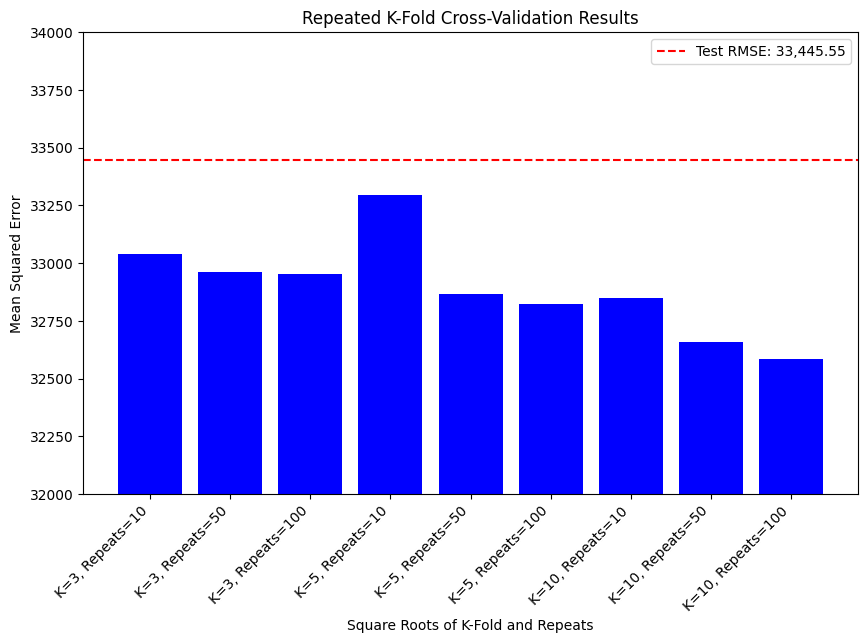

In [176]:
# plot bar chart
plt.figure(figsize=(10, 6))
plt.bar(labels, results_r, color='blue')
plt.axhline(y=rmse_test, color='r', linestyle='--', label=f"Test RMSE: {rmse_test:,.2f}")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Mean Squared Error")
plt.xlabel("Square Roots of K-Fold and Repeats")
plt.title("Repeated K-Fold Cross-Validation Results")
plt.ylim(32000, 34000)
plt.legend()
plt.show()

## Appendix: Explanation of Features in Ames Housing Dataset

### **Identification**
- `PID` → Parcel Identification Number (unique identifier for each property)
- `Order` → Row number (used for indexing, not a feature)

---

### **Sale Information**
- `SalePrice` → The final selling price of the house in USD (**Target variable**)
- `Mo Sold` → Month the house was sold (1 = January, ..., 12 = December)
- `Yr Sold` → Year the house was sold
- `Sale Type` → Type of sale (e.g., **WD** = Warranty Deed, **New** = Newly Built)
- `Sale Condition` → Condition of the sale (e.g., **Normal**, **Abnormal**, **Partial** for incomplete homes)

---

### **General Property Information**
- `MS SubClass` → Type of dwelling (e.g., **20 = 1-story**, **60 = 2-story**, **120 = Townhouse**)
- `MS Zoning` → Zoning classification (e.g., **RL = Residential Low Density**, **C = Commercial**)
- `Lot Frontage` → Linear feet of street connected to property
- `Lot Area` → Total size of the lot in square feet
- `Neighborhood` → Physical locations within Ames (e.g., **CollgCr = College Creek**)
- `Condition 1` / `Condition 2` → Proximity to roads or railroads (e.g., **Norm = Normal**, **PosN = Near Park**)

---

### **Building & House Design**
- `Bldg Type` → Type of dwelling (e.g., **1Fam = Single Family**, **Twnhs = Townhouse**)
- `House Style` → Style of the house (e.g., **1Story = One Story**, **2Story = Two Story**, **SplitFoyer**)
- `Overall Qual` → Overall quality of materials (scale: **1 = Very Poor** to **10 = Excellent**)
- `Overall Cond` → Overall condition of the house (scale: **1 = Very Poor** to **10 = Excellent**)

---

### **Year Built & Remodel**
- `Year Built` → Original construction year
- `Year Remod/Add` → Year of last remodel or addition

---

### **Exterior Features**
- `Exterior 1st` / `Exterior 2nd` → Exterior covering material (e.g., **VinylSd = Vinyl Siding**, **HdBoard = Hardboard**)
- `Mas Vnr Type` → Masonry veneer type (e.g., **BrkFace = Brick Face**, **None = No Veneer**)
- `Mas Vnr Area` → Area of masonry veneer in square feet

---

### **Basement Features**
- `Bsmt Qual` → Basement height (e.g., **Ex = Excellent**, **TA = Typical**, **Po = Poor**)
- `Bsmt Cond` → General condition of the basement
- `Bsmt Exposure` → Walkout or garden level basement?
- `BsmtFin Type 1` / `BsmtFin SF 1` → Primary finished area in basement (e.g., **GLQ = Good Living Quarters**)
- `BsmtFin Type 2` / `BsmtFin SF 2` → Secondary finished area
- `Bsmt Unf SF` → Unfinished square feet in basement
- `Total Bsmt SF` → Total square footage of basement

---

### **Utilities & HVAC**
- `Heating` → Type of heating system (e.g., **GasA = Gas Forced Air**, **OthW = Hot Water Heating**)
- `Heating QC` → Quality of heating system (e.g., **Ex = Excellent**, **Fa = Fair**)
- `Central Air` → **Y = Yes**, **N = No**
- `Electrical` → Electrical system (e.g., **SBrkr = Standard Breaker**, **FuseA = Fuse Box**)

---

### **Above Ground Living Area**
- `1st Flr SF` → First-floor square footage
- `2nd Flr SF` → Second-floor square footage
- `Gr Liv Area` → Total **above-ground** living area in square feet
- `Low Qual Fin SF` → Low-quality finished square feet (e.g., unfinished rooms)

---

### **Bathrooms & Bedrooms**
- `Full Bath` → Full bathrooms above ground
- `Half Bath` → Half bathrooms above ground
- `Bsmt Full Bath` → Full bathrooms in basement
- `Bsmt Half Bath` → Half bathrooms in basement
- `Bedroom AbvGr` → Number of bedrooms above ground
- `Kitchen AbvGr` → Number of kitchens above ground
- `Kitchen Qual` → Kitchen quality (**Ex = Excellent**, **Fa = Fair**)

---

### **Garage Features**
- `Garage Type` → Type of garage (e.g., **Attchd = Attached**, **Detchd = Detached**)
- `Garage Yr Blt` → Year garage was built
- `Garage Finish` → Interior finish of garage
- `Garage Cars` → Size of garage in car capacity
- `Garage Area` → Garage size in square feet

---

### **Additional Features**
- `Fireplaces` → Number of fireplaces
- `Fireplace Qu` → Fireplace quality
- `Paved Drive` → Paved driveway? (**Y = Yes, P = Partial, N = No**)
- `Wood Deck SF` → Square footage of wood deck
- `Open Porch SF` → Square footage of open porch
- `Enclosed Porch` → Square footage of enclosed porch
- `Screen Porch` → Square footage of screened porch
- `Pool Area` → Pool area in square feet
- `Misc Val` → Miscellaneous features (e.g., shed value)

